In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_score, recall_score, roc_curve, auc
import matplotlib.pyplot as plt

df = pd.read_csv('course_lead_scoring.csv')

cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

TARGET = 'converted'
if TARGET not in df.columns:
    raise RuntimeError(f"Kolom target '{TARGET}' tidak ditemukan di df. Ubah variabel TARGET jika perlu.")

# remove target from feature lists if present
if TARGET in cat_cols:
    cat_cols.remove(TARGET)
if TARGET in num_cols:
    num_cols.remove(TARGET)

df_prep = df.copy()
for c in cat_cols:
    df_prep[c] = df_prep[c].fillna('NA')
for c in num_cols:
    df_prep[c] = df_prep[c].fillna(0.0)

df_full_train, df_test = train_test_split(df_prep, test_size=0.2, random_state=1, stratify=df_prep[TARGET])
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1, stratify=df_full_train[TARGET])

print("Sizes: full_train={}, train={}, val={}, test={}".format(len(df_full_train), len(df_train), len(df_val), len(df_test)))

Sizes: full_train=1169, train=876, val=293, test=293


In [3]:
vars_to_check = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']
missing_vars = [v for v in vars_to_check if v not in df_train.columns]
if missing_vars:
    raise RuntimeError(f"Variabel berikut tidak ada di data: {missing_vars}. Pastikan kolom tersedia.")

from sklearn.metrics import roc_auc_score
auc_dict = {}
y_train = df_train[TARGET].values

for v in vars_to_check:
    # we must ensure numeric series
    scores = df_train[v].astype(float).values
    try:
        auc_val = roc_auc_score(y_train, scores)
    except ValueError as e:
        # if only one class present, roc_auc_score fails
        auc_val = np.nan
    # invert if < 0.5 as requested
    if not np.isnan(auc_val) and auc_val < 0.5:
        scores = -scores
        auc_val = roc_auc_score(y_train, scores)
    auc_dict[v] = auc_val

print("\nAUC per variable (on TRAIN, with inversion if <0.5):")
for k,v in auc_dict.items():
    print(f"  {k}: {v:.6f}")

var_best = max(auc_dict, key=lambda k: (np.nan_to_num(auc_dict[k], -1.0)))
print("\nQuestion 1 answer: variable with highest AUC =", var_best)


AUC per variable (on TRAIN, with inversion if <0.5):
  lead_score: 0.617792
  number_of_courses_viewed: 0.751909
  interaction_count: 0.705731
  annual_income: 0.567474

Question 1 answer: variable with highest AUC = number_of_courses_viewed


In [4]:
def prepare_X(df_):
    features = df_.drop(columns=[TARGET]).to_dict(orient='records')
    return features

dv = DictVectorizer(sparse=False)

X_train_dict = prepare_X(df_train)
X_val_dict = prepare_X(df_val)
X_train = dv.fit_transform(X_train_dict)
X_val = dv.transform(X_val_dict)
y_train = df_train[TARGET].values
y_val = df_val[TARGET].values

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)
y_val_pred_proba = model.predict_proba(X_val)[:,1]
auc_val_model = roc_auc_score(y_val, y_val_pred_proba)
print(f"\nQuestion 2: Validation AUC = {auc_val_model:.3f}")

# Choose among options [0.32, 0.52, 0.72, 0.92]
options_q2 = [0.32, 0.52, 0.72, 0.92]
closest_q2 = min(options_q2, key=lambda x: abs(x - round(auc_val_model,3)))
print("Closest option for Question 2:", closest_q2)


Question 2: Validation AUC = 0.900
Closest option for Question 2: 0.92


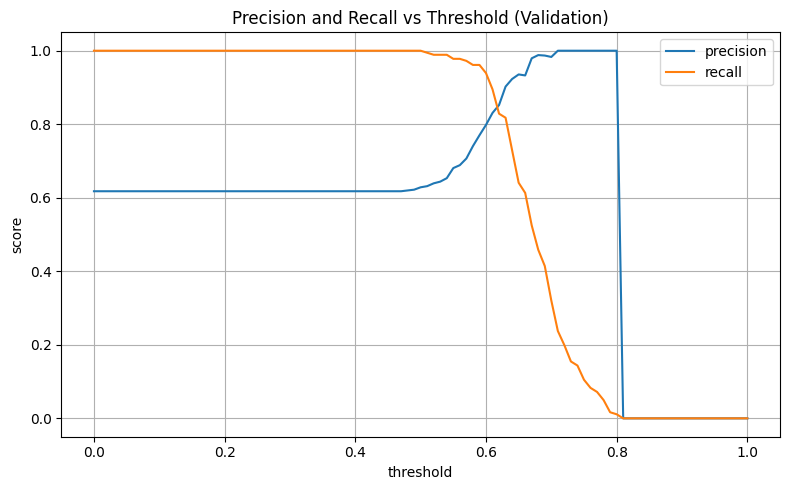


Question 3: intersection threshold ≈ 0.810
Closest option for Question 3: 0.745


In [5]:
thresholds = np.arange(0.0, 1.001, 0.01)
precisions = []
recalls = []

y_scores = y_val_pred_proba

for t in thresholds:
    y_pred = (y_scores >= t).astype(int)
    # If no positive predictions, precision_score gives ill-defined; handle:
    if y_pred.sum() == 0:
        precisions.append(1.0 if y_val.sum()==0 else 0.0)  # if no positives in both, precision=1; else 0
    else:
        precisions.append(precision_score(y_val, y_pred, zero_division=0))
    recalls.append(recall_score(y_val, y_pred, zero_division=0))

# plot
plt.figure(figsize=(8,5))
plt.plot(thresholds, precisions, label='precision')
plt.plot(thresholds, recalls, label='recall')
plt.xlabel('threshold')
plt.ylabel('score')
plt.legend()
plt.grid(True)
plt.title('Precision and Recall vs Threshold (Validation)')
plt.tight_layout()
plt.show()

# find threshold where curves intersect (abs diff minimal)
diffs = np.abs(np.array(precisions) - np.array(recalls))
idx_min = np.argmin(diffs)
thr_intersect = thresholds[idx_min]
print(f"\nQuestion 3: intersection threshold ≈ {thr_intersect:.3f}")

# Closest provided options [0.145, 0.345, 0.545, 0.745]
options_q3 = [0.145, 0.345, 0.545, 0.745]
closest_q3 = min(options_q3, key=lambda x: abs(x - thr_intersect))
print("Closest option for Question 3:", closest_q3)

In [6]:
f1s = []
for p, r in zip(precisions, recalls):
    if (p + r) == 0:
        f1s.append(0.0)
    else:
        f1s.append(2 * p * r / (p + r))

idx_best = np.argmax(f1s)
thr_best_f1 = thresholds[idx_best]
print(f"\nQuestion 4: threshold with max F1 ≈ {thr_best_f1:.3f} (F1={f1s[idx_best]:.3f})")

options_q4 = [0.14, 0.34, 0.54, 0.74]
closest_q4 = min(options_q4, key=lambda x: abs(x - thr_best_f1))
print("Closest option for Question 4:", closest_q4)


Question 4: threshold with max F1 ≈ 0.600 (F1=0.863)
Closest option for Question 4: 0.54


In [7]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)
auc_scores = []
X_full_dict = prepare_X(df_full_train)
X_full = dv.fit_transform(X_full_dict)  # note: refit dv on full_train
y_full = df_full_train[TARGET].values

for train_idx, val_idx in kf.split(X_full):
    X_tr, X_v = X_full[train_idx], X_full[val_idx]
    y_tr, y_v = y_full[train_idx], y_full[val_idx]
    m = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    m.fit(X_tr, y_tr)
    y_v_pred = m.predict_proba(X_v)[:,1]
    auc_scores.append(roc_auc_score(y_v, y_v_pred))

auc_scores = np.array(auc_scores)
print("\nQuestion 5: 5-fold AUC scores:", np.round(auc_scores, 6))
std_scores = auc_scores.std()
print("Std of AUC across folds =", std_scores)

options_q5 = [0.0001, 0.006, 0.06, 0.36]
closest_q5 = min(options_q5, key=lambda x: abs(x - std_scores))
print("Closest option for Question 5:", closest_q5)


Question 5: 5-fold AUC scores: [0.801253 0.837484 0.861607 0.778016 0.806095]
Std of AUC across folds = 0.029312137624452266
Closest option for Question 5: 0.006


In [8]:
Cs = [1e-6, 1e-3, 1]
results = {}
for C in Cs:
    scores = []
    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    # Recreate dv each C to avoid leakage; use df_full_train features
    X_full_dict = prepare_X(df_full_train)
    dv_temp = DictVectorizer(sparse=False)
    X_full_temp = dv_temp.fit_transform(X_full_dict)
    y_full_temp = df_full_train[TARGET].values
    for train_idx, val_idx in kf.split(X_full_temp):
        X_tr, X_v = X_full_temp[train_idx], X_full_temp[val_idx]
        y_tr, y_v = y_full_temp[train_idx], y_full_temp[val_idx]
        m = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        m.fit(X_tr, y_tr)
        y_v_pred = m.predict_proba(X_v)[:,1]
        scores.append(roc_auc_score(y_v, y_v_pred))
    scores = np.array(scores)
    results[C] = (np.round(scores.mean(), 3), np.round(scores.std(), 3))
    print(f"C={C}: mean={results[C][0]}, std={results[C][1]}")

# Select best C: highest mean; if tie, lowest std; if still tie, smallest C
best = None
for C in sorted(results.keys()):
    mean, std = results[C]
    if best is None:
        best = (C, mean, std)
    else:
        if mean > best[1]:
            best = (C, mean, std)
        elif mean == best[1]:
            if std < best[2]:
                best = (C, mean, std)
            elif std == best[2]:
                if C < best[0]:
                    best = (C, mean, std)

print("\nQuestion 6: Best C =", best[0], "with mean", best[1], "std", best[2])


C=1e-06: mean=0.561, std=0.035
C=0.001: mean=0.86, std=0.026
C=1: mean=0.817, std=0.029

Question 6: Best C = 0.001 with mean 0.86 std 0.026
